In [1]:
!pip install "deeplake<4"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import deeplake
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Data augmentation for training set
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# No augmentation for validation/test
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [5]:
ds_full = deeplake.load('hub://activeloop/fer2013-train')
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



|

hub://activeloop/fer2013-train loaded successfully.



In [6]:
total_size = len(ds_full)
indices = np.arange(total_size)

# First split: train vs temp (val+test)
train_indices, temp_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)
# Second split: validation vs test
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42, shuffle=True
)


def label_transform(labels):
    # Convert to tensor if it's a numpy array, then ensure long dtype and remove extra dimensions
    return torch.as_tensor(labels).squeeze().long()

train_loader = ds_full.pytorch(
    indices=train_indices,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    transform={'images': train_transforms, 'labels': label_transform}
)

val_loader = ds_full.pytorch(
    indices=val_indices,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    transform={'images': val_test_transforms, 'labels': label_transform}
)

test_loader = ds_full.pytorch(
    indices=test_indices,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    transform={'images': val_test_transforms, 'labels': label_transform}
)


In [7]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 7)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(-1, 128 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

#hyperparameters
lr=0.001
num_epochs=30
batch_size=32

# Initialize model
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
print(f"Model : {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Model : 1274375 parameters


In [9]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(train_loader):
        images = batch['images'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Simple validation function
def validate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['images'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [10]:
best_accuracy = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    print(f'Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    print(f'Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')

    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best model saved! Accuracy: {val_acc:.2f}%')


Epoch 1/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:59, 7.94MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<04:02, 7.84MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.9424
Batch [100/898], Loss: 1.9133
Batch [200/898], Loss: 1.9396
Batch [300/898], Loss: 1.9030
Batch [400/898], Loss: 1.6959
Batch [500/898], Loss: 1.7693
Batch [600/898], Loss: 1.7971
Batch [700/898], Loss: 1.8200
Batch [800/898], Loss: 1.6256
Training - Loss: 1.7281, Accuracy: 29.59%
Validation - Loss: 1.5057, Accuracy: 41.75%
New best model saved! Accuracy: 41.75%

Epoch 2/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:19<03:05, 10.3MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:20<04:18, 7.35MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.5189
Batch [100/898], Loss: 1.6552
Batch [200/898], Loss: 1.6346
Batch [300/898], Loss: 1.1656
Batch [400/898], Loss: 1.5789
Batch [500/898], Loss: 1.5104
Batch [600/898], Loss: 1.3388
Batch [700/898], Loss: 1.5260
Batch [800/898], Loss: 1.4992
Training - Loss: 1.5172, Accuracy: 40.64%
Validation - Loss: 1.3534, Accuracy: 48.56%
New best model saved! Accuracy: 48.56%

Epoch 3/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<03:25, 9.24MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<04:09, 7.62MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2946
Batch [100/898], Loss: 1.6510
Batch [200/898], Loss: 1.2653
Batch [300/898], Loss: 1.3007
Batch [400/898], Loss: 1.5245
Batch [500/898], Loss: 1.3289
Batch [600/898], Loss: 1.2759
Batch [700/898], Loss: 1.5971
Batch [800/898], Loss: 1.2313
Training - Loss: 1.4139, Accuracy: 45.78%
Validation - Loss: 1.2833, Accuracy: 50.90%
New best model saved! Accuracy: 50.90%

Epoch 4/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:06, 10.2MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<04:02, 7.83MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2592
Batch [100/898], Loss: 1.3474
Batch [200/898], Loss: 1.4906
Batch [300/898], Loss: 1.1853
Batch [400/898], Loss: 1.1901
Batch [500/898], Loss: 1.3234
Batch [600/898], Loss: 1.2603
Batch [700/898], Loss: 1.1445
Batch [800/898], Loss: 1.1602
Training - Loss: 1.3595, Accuracy: 48.09%
Validation - Loss: 1.2317, Accuracy: 53.22%
New best model saved! Accuracy: 53.22%

Epoch 5/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<04:13, 7.50MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<04:00, 7.89MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.5551
Batch [100/898], Loss: 1.3186
Batch [200/898], Loss: 1.4546
Batch [300/898], Loss: 1.5528
Batch [400/898], Loss: 1.3798
Batch [500/898], Loss: 1.1537
Batch [600/898], Loss: 1.1053
Batch [700/898], Loss: 0.9900
Batch [800/898], Loss: 1.0478
Training - Loss: 1.3216, Accuracy: 49.45%
Validation - Loss: 1.2148, Accuracy: 53.75%
New best model saved! Accuracy: 53.75%

Epoch 6/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:04, 10.3MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:56, 8.03MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.4631
Batch [100/898], Loss: 1.3687
Batch [200/898], Loss: 1.2517
Batch [300/898], Loss: 1.4599
Batch [400/898], Loss: 1.1106
Batch [500/898], Loss: 1.9399
Batch [600/898], Loss: 0.9947
Batch [700/898], Loss: 0.9422
Batch [800/898], Loss: 1.2883
Training - Loss: 1.2966, Accuracy: 50.58%
Validation - Loss: 1.1670, Accuracy: 55.82%
New best model saved! Accuracy: 55.82%

Epoch 7/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:20<04:50, 6.54MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:20<04:17, 7.38MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2966
Batch [100/898], Loss: 1.4343
Batch [200/898], Loss: 1.3476
Batch [300/898], Loss: 1.3837
Batch [400/898], Loss: 1.4740
Batch [500/898], Loss: 1.3898
Batch [600/898], Loss: 1.1231
Batch [700/898], Loss: 1.2615
Batch [800/898], Loss: 1.5148
Training - Loss: 1.2762, Accuracy: 51.24%
Validation - Loss: 1.1447, Accuracy: 56.37%
New best model saved! Accuracy: 56.37%

Epoch 8/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:08, 10.1MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:57, 8.01MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.4683
Batch [100/898], Loss: 1.6603
Batch [200/898], Loss: 1.1583
Batch [300/898], Loss: 1.2992
Batch [400/898], Loss: 1.4487
Batch [500/898], Loss: 1.5430
Batch [600/898], Loss: 1.8822
Batch [700/898], Loss: 1.0814
Batch [800/898], Loss: 1.0574
Training - Loss: 1.2581, Accuracy: 52.23%
Validation - Loss: 1.1502, Accuracy: 55.98%

Epoch 9/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:19<04:43, 6.70MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<04:05, 7.74MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2630
Batch [100/898], Loss: 1.2238
Batch [200/898], Loss: 1.3623
Batch [300/898], Loss: 1.6189
Batch [400/898], Loss: 1.3493
Batch [500/898], Loss: 1.3137
Batch [600/898], Loss: 1.3912
Batch [700/898], Loss: 0.8726
Batch [800/898], Loss: 1.2667
Training - Loss: 1.2426, Accuracy: 52.60%
Validation - Loss: 1.1145, Accuracy: 57.63%
New best model saved! Accuracy: 57.63%

Epoch 10/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:17<04:05, 7.76MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:17<03:48, 8.32MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.0421
Batch [100/898], Loss: 1.3725
Batch [200/898], Loss: 1.3285
Batch [300/898], Loss: 1.1273
Batch [400/898], Loss: 1.2248
Batch [500/898], Loss: 1.1650
Batch [600/898], Loss: 1.1119
Batch [700/898], Loss: 1.1514
Batch [800/898], Loss: 1.1633
Training - Loss: 1.2359, Accuracy: 53.58%
Validation - Loss: 1.1306, Accuracy: 57.09%

Epoch 11/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:19<04:17, 7.40MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<04:13, 7.49MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.0771
Batch [100/898], Loss: 1.0249
Batch [200/898], Loss: 1.2795
Batch [300/898], Loss: 1.3595
Batch [400/898], Loss: 1.5527
Batch [500/898], Loss: 1.0266
Batch [600/898], Loss: 0.9304
Batch [700/898], Loss: 1.3250
Batch [800/898], Loss: 1.2123
Training - Loss: 1.2201, Accuracy: 53.63%
Validation - Loss: 1.1023, Accuracy: 57.91%
New best model saved! Accuracy: 57.91%

Epoch 12/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:15, 9.73MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:57, 8.01MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 0.9271
Batch [100/898], Loss: 1.0209
Batch [200/898], Loss: 1.0303
Batch [300/898], Loss: 1.1458
Batch [400/898], Loss: 1.1523
Batch [500/898], Loss: 1.2620
Batch [600/898], Loss: 1.2541
Batch [700/898], Loss: 1.0832
Batch [800/898], Loss: 1.2643
Training - Loss: 1.2169, Accuracy: 53.92%
Validation - Loss: 1.1069, Accuracy: 57.81%

Epoch 13/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:55, 8.06MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:55, 8.07MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.1543
Batch [100/898], Loss: 0.9151
Batch [200/898], Loss: 0.8647
Batch [300/898], Loss: 0.9390
Batch [400/898], Loss: 1.4265
Batch [500/898], Loss: 1.3806
Batch [600/898], Loss: 1.2960
Batch [700/898], Loss: 1.0563
Batch [800/898], Loss: 0.8587
Training - Loss: 1.2027, Accuracy: 54.20%
Validation - Loss: 1.0838, Accuracy: 58.79%
New best model saved! Accuracy: 58.79%

Epoch 14/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:16, 9.66MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<04:02, 7.83MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.3506
Batch [100/898], Loss: 1.0825
Batch [200/898], Loss: 1.1907
Batch [300/898], Loss: 1.0326
Batch [400/898], Loss: 0.7730
Batch [500/898], Loss: 0.9505
Batch [600/898], Loss: 1.3761
Batch [700/898], Loss: 1.3269
Batch [800/898], Loss: 1.1275
Training - Loss: 1.2062, Accuracy: 54.51%
Validation - Loss: 1.0944, Accuracy: 58.70%

Epoch 15/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:03, 10.3MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:57, 7.99MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.1335
Batch [100/898], Loss: 0.8747
Batch [200/898], Loss: 1.5904
Batch [300/898], Loss: 1.4043
Batch [400/898], Loss: 1.2821
Batch [500/898], Loss: 1.3608
Batch [600/898], Loss: 1.0589
Batch [700/898], Loss: 1.3469
Batch [800/898], Loss: 1.0385
Training - Loss: 1.1955, Accuracy: 54.85%
Validation - Loss: 1.0543, Accuracy: 59.33%
New best model saved! Accuracy: 59.33%

Epoch 16/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:23<03:11, 9.92MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:23<05:05, 6.21MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2696
Batch [100/898], Loss: 1.5499
Batch [200/898], Loss: 1.1147
Batch [300/898], Loss: 1.2165
Batch [400/898], Loss: 1.0752
Batch [500/898], Loss: 1.1253
Batch [600/898], Loss: 1.0531
Batch [700/898], Loss: 1.4852
Batch [800/898], Loss: 1.3398
Training - Loss: 1.1910, Accuracy: 55.16%
Validation - Loss: 1.0474, Accuracy: 60.17%
New best model saved! Accuracy: 60.17%

Epoch 17/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:22, 9.40MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:58, 7.97MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 0.9842
Batch [100/898], Loss: 0.8849
Batch [200/898], Loss: 1.1997
Batch [300/898], Loss: 0.9196
Batch [400/898], Loss: 1.2501
Batch [500/898], Loss: 1.3173
Batch [600/898], Loss: 1.0195
Batch [700/898], Loss: 1.1527
Batch [800/898], Loss: 1.1639
Training - Loss: 1.1831, Accuracy: 55.58%
Validation - Loss: 1.1083, Accuracy: 57.92%

Epoch 18/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<03:24, 9.31MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<04:15, 7.43MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.1320
Batch [100/898], Loss: 1.1747
Batch [200/898], Loss: 1.1202
Batch [300/898], Loss: 0.8599
Batch [400/898], Loss: 0.8787
Batch [500/898], Loss: 1.1460
Batch [600/898], Loss: 1.3180
Batch [700/898], Loss: 1.1446
Batch [800/898], Loss: 1.3327
Training - Loss: 1.1777, Accuracy: 55.52%
Validation - Loss: 1.0577, Accuracy: 60.09%

Epoch 19/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:17<03:00, 10.5MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:17<03:49, 8.29MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2073
Batch [100/898], Loss: 1.1777
Batch [200/898], Loss: 1.2055
Batch [300/898], Loss: 1.0673
Batch [400/898], Loss: 1.2847
Batch [500/898], Loss: 1.4983
Batch [600/898], Loss: 1.1599
Batch [700/898], Loss: 0.9166
Batch [800/898], Loss: 0.9247
Training - Loss: 1.1701, Accuracy: 55.62%
Validation - Loss: 1.0438, Accuracy: 60.40%
New best model saved! Accuracy: 60.40%

Epoch 20/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:35, 8.83MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:52, 8.18MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.3622
Batch [100/898], Loss: 1.2210
Batch [200/898], Loss: 1.2230
Batch [300/898], Loss: 1.1592
Batch [400/898], Loss: 1.0873
Batch [500/898], Loss: 1.3163
Batch [600/898], Loss: 1.0924
Batch [700/898], Loss: 1.1086
Batch [800/898], Loss: 1.3944
Training - Loss: 1.1651, Accuracy: 55.66%
Validation - Loss: 1.0502, Accuracy: 60.16%

Epoch 21/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<02:58, 10.7MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:57, 7.99MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2921
Batch [100/898], Loss: 1.3135
Batch [200/898], Loss: 1.3694
Batch [300/898], Loss: 1.1442
Batch [400/898], Loss: 1.3173
Batch [500/898], Loss: 1.3247
Batch [600/898], Loss: 1.0883
Batch [700/898], Loss: 1.0860
Batch [800/898], Loss: 0.7377
Training - Loss: 1.1665, Accuracy: 55.98%
Validation - Loss: 1.0366, Accuracy: 60.78%
New best model saved! Accuracy: 60.78%

Epoch 22/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:18<03:20, 9.47MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:59, 7.93MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.3386
Batch [100/898], Loss: 1.2390
Batch [200/898], Loss: 1.4480
Batch [300/898], Loss: 0.9996
Batch [400/898], Loss: 0.9942
Batch [500/898], Loss: 1.3086
Batch [600/898], Loss: 0.8880
Batch [700/898], Loss: 1.0807
Batch [800/898], Loss: 1.1581
Training - Loss: 1.1608, Accuracy: 55.81%
Validation - Loss: 1.0419, Accuracy: 60.41%

Epoch 23/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:19<03:25, 9.26MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<04:05, 7.73MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 0.9039
Batch [100/898], Loss: 0.9312
Batch [200/898], Loss: 1.2982
Batch [300/898], Loss: 1.4683
Batch [400/898], Loss: 1.0945
Batch [500/898], Loss: 0.9960
Batch [600/898], Loss: 1.0159
Batch [700/898], Loss: 1.2482
Batch [800/898], Loss: 0.9718
Training - Loss: 1.1601, Accuracy: 56.24%
Validation - Loss: 1.0236, Accuracy: 60.98%
New best model saved! Accuracy: 60.98%

Epoch 24/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:17<04:10, 7.59MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:17<03:50, 8.25MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.2662
Batch [100/898], Loss: 1.2791
Batch [200/898], Loss: 1.4066
Batch [300/898], Loss: 1.4384
Batch [400/898], Loss: 0.9978
Batch [500/898], Loss: 0.9989
Batch [600/898], Loss: 1.4614
Batch [700/898], Loss: 1.2555
Batch [800/898], Loss: 1.1152
Training - Loss: 1.1548, Accuracy: 56.37%
Validation - Loss: 1.0363, Accuracy: 60.83%

Epoch 25/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:21<03:17, 9.63MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:21<04:40, 6.78MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.1263
Batch [100/898], Loss: 1.3880
Batch [200/898], Loss: 1.2375
Batch [300/898], Loss: 1.1784
Batch [400/898], Loss: 1.2996
Batch [500/898], Loss: 1.2605
Batch [600/898], Loss: 1.1147
Batch [700/898], Loss: 1.1017
Batch [800/898], Loss: 0.9742
Training - Loss: 1.1605, Accuracy: 56.16%
Validation - Loss: 1.0129, Accuracy: 61.91%
New best model saved! Accuracy: 61.91%

Epoch 26/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:09, 10.0MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<03:56, 8.04MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.0906
Batch [100/898], Loss: 1.1236
Batch [200/898], Loss: 1.0540
Batch [300/898], Loss: 0.9213
Batch [400/898], Loss: 1.2225
Batch [500/898], Loss: 0.9420
Batch [600/898], Loss: 1.3905
Batch [700/898], Loss: 1.2667
Batch [800/898], Loss: 1.1343
Training - Loss: 1.1412, Accuracy: 56.75%
Validation - Loss: 1.0015, Accuracy: 62.35%
New best model saved! Accuracy: 62.35%

Epoch 27/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:20<03:10, 9.97MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:20<04:23, 7.22MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.0392
Batch [100/898], Loss: 0.9331
Batch [200/898], Loss: 1.1705
Batch [300/898], Loss: 1.1144
Batch [400/898], Loss: 1.4784
Batch [500/898], Loss: 1.1067
Batch [600/898], Loss: 1.0355
Batch [700/898], Loss: 0.8842
Batch [800/898], Loss: 1.2919
Training - Loss: 1.1445, Accuracy: 56.73%
Validation - Loss: 1.0070, Accuracy: 62.23%

Epoch 28/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:17<04:11, 7.55MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:17<03:49, 8.29MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.1562
Batch [100/898], Loss: 1.0279
Batch [200/898], Loss: 1.2003
Batch [300/898], Loss: 1.1037
Batch [400/898], Loss: 1.2937
Batch [500/898], Loss: 0.9014
Batch [600/898], Loss: 1.3736
Batch [700/898], Loss: 0.8701
Batch [800/898], Loss: 1.0890
Training - Loss: 1.1422, Accuracy: 57.08%
Validation - Loss: 0.9834, Accuracy: 62.89%
New best model saved! Accuracy: 62.89%

Epoch 29/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 140M/1.91G [00:19<02:55, 10.9MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:19<04:06, 7.71MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 1.0922
Batch [100/898], Loss: 0.8442
Batch [200/898], Loss: 1.2733
Batch [300/898], Loss: 1.0293
Batch [400/898], Loss: 1.3680
Batch [500/898], Loss: 0.9228
Batch [600/898], Loss: 1.1009
Batch [700/898], Loss: 1.1568
Batch [800/898], Loss: 1.0848
Training - Loss: 1.1363, Accuracy: 56.67%
Validation - Loss: 0.9938, Accuracy: 62.03%

Epoch 30/30
------------------------------


Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<04:00, 7.90MB/s]/usr/local/lib/python3.11/dist-packages/deeplake/util/warnings.py:7: UserWarning: `MAX_TENSORS_IN_SHUFFLE_BUFFER` of 32000 reached. Shuffle buffer will not be filled up to the `buffer_size` limit of 2.05e+03 MB.
  warnings.warn(*args, **kwargs)
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 141M/1.91G [00:18<04:03, 7.80MB/s]


Shuffle buffer filling is complete.
Batch [0/898], Loss: 0.9974
Batch [100/898], Loss: 1.0807
Batch [200/898], Loss: 1.2744
Batch [300/898], Loss: 1.0759
Batch [400/898], Loss: 0.9974
Batch [500/898], Loss: 0.9629
Batch [600/898], Loss: 1.3708
Batch [700/898], Loss: 1.2622
Batch [800/898], Loss: 1.2651
Training - Loss: 1.1354, Accuracy: 57.27%
Validation - Loss: 0.9955, Accuracy: 62.25%


In [11]:
print(f'\nTraining completed!')
print(f'Best validation accuracy: {best_accuracy:.2f}%')


Training completed!
Best validation accuracy: 62.89%


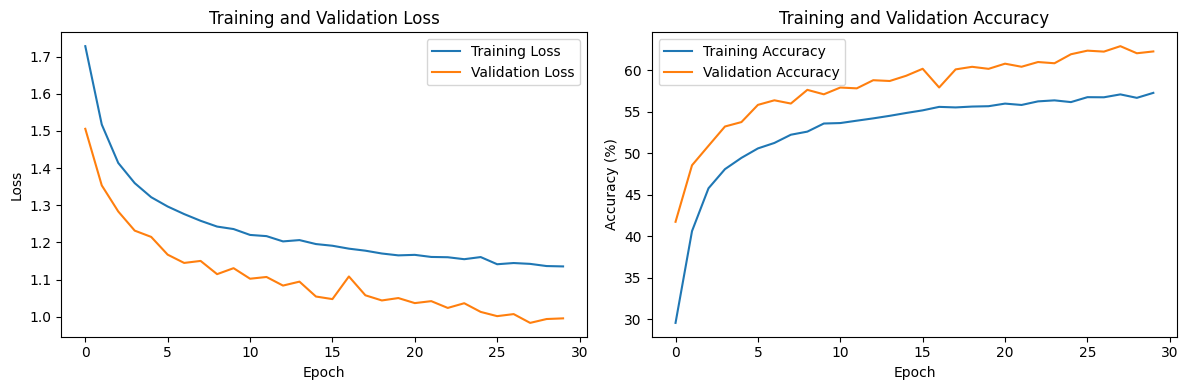


Testing model on sample images...


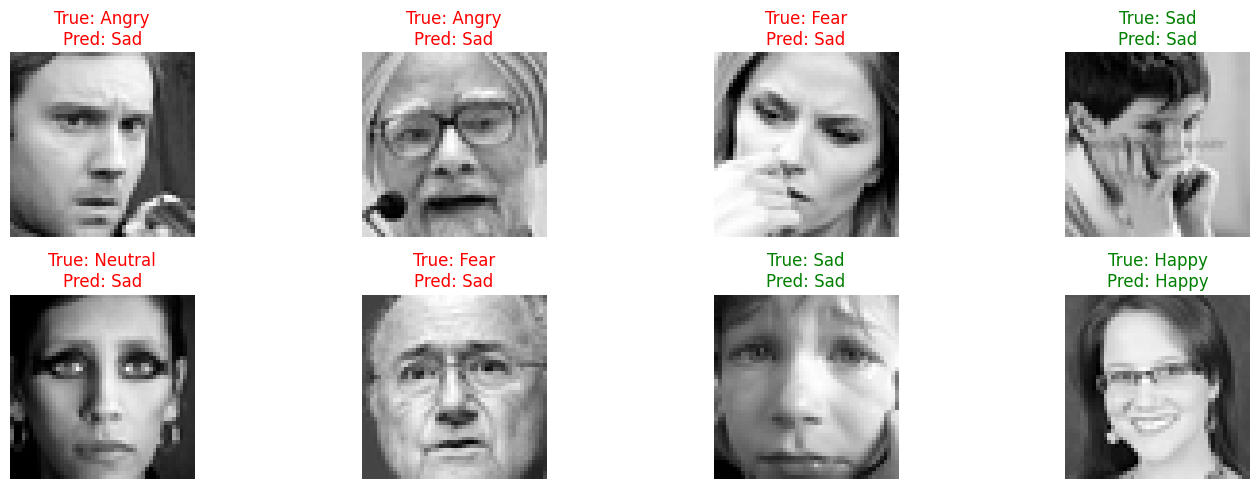


Final model evaluation:
Final Test Loss: 0.9955
Final Test Accuracy: 62.25%


In [12]:
# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Test a few samples
def test_samples(model, test_loader, num_samples=8):
    model.eval()

    # Get one batch
    batch = next(iter(test_loader))
    images = batch['images'][:num_samples].to(device)
    labels = batch['labels'][:num_samples].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot results
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, 4, i+1)
        img = images[i].cpu().squeeze().numpy()
        plt.imshow(img, cmap='gray')

        true_label = emotions[labels[i].item()]
        pred_label = emotions[predicted[i].item()]

        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test some samples
print("\nTesting model on sample images...")
test_samples(model, test_loader)

# Final evaluation
print("\nFinal model evaluation:")
final_loss, final_accuracy = validate(model, test_loader, criterion)
print(f'Final Test Loss: {final_loss:.4f}')
print(f'Final Test Accuracy: {final_accuracy:.2f}%')
